In [1]:
import numpy as np

from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse import csr_matrix, coo_matrix, linalg
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import itertools
import matplotlib

import random

import pandas as pd
from sklearn.metrics import roc_curve, auc


def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'], dtype="F")


def gen_nmf(A, n_components, save=False):
    nmf_model = NMF(n_components=n_components)
    W = nmf_model.fit_transform(A);
    H = nmf_model.components_;
    if save:
        save_sparse_csr("data/nmf_W_"+int(n_components), csr_matrix(W))
        save_sparse_csr("data/nmf_H_"+int(n_components), csr_matrix(H))
    return W, H


def gen_svd(counts, k, save=False):
    U, s, VT = linalg.svds(counts, k=k)
    sigma = np.diag(s)
    if save:
        save_sparse_csr("data/U",csr_matrix(U))
        save_sparse_csr("data/sigma",csr_matrix(sigma))
        save_sparse_csr("data/VT",csr_matrix(VT))
    return U, sigma, VT


def load_test_DF():
    dftest = pd.read_csv('data/testTriplets.txt',
        header=None,
        index_col=None,
        sep=' ',
        names=['sender','receiver','transaction'])
    return dftest


def plot_test_roc(raw_pred, dftest, filename=None, threshold=None):
    pred = []
    if threshold is not None:
        for p in raw_pred:
            val = 0 if p < threshold else 1
            pred.append(val)
    else:
        pred = raw_pred

    label = dftest['transaction']
    fpr, tpr, thresholds = roc_curve(label, pred)
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    matplotlib.rcParams['figure.figsize'] = (10, 10)
    plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename)
    plt.show()


def get_predictions_svd(U, sigma, VT, dftest):
    pred = [np.sum(U[row['sender'],:] * sigma * VT[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
    return np.array(pred).astype(float)


def get_predictions_nmf(W, H, dftest):
    pred = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
            for index,row in dftest.iterrows()]
    return np.array(pred).astype(float)

In [2]:
# counts = load_sparse_csr("data/counts.npz").astype('int')
# dftest = load_test_DF()

# Explore binary transaction type rather than frequency
dftrain = pd.read_csv('data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])

dim = max((dftrain['sender'].max(),
           dftrain['receiver'].max(),
           dftest['sender'].max(),
           dftest['receiver'].max()))

dim += 1

convert_to_bin_trans = True
if convert_to_bin_trans:
    dftrain['transaction'] = np.array(dftrain['transaction'].tolist()).astype('bool').astype('int')

counts = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)

In [ ]:
prefix = 'bin_nmf_' if convert_to_bin_trans else 'nmf_'

for n_comps in range(2, 21):
    W, H = gen_nmf(counts, n_comps)
    pred = get_predictions_nmf(W, H, dftest)
    plot_test_roc(pred, dftest, filename='roc/' + prefix + str(n_comps) + '.png')
    np.savetxt('preds/pred_' + prefix + str(n_comps) + '.txt', pred)

Area under the ROC curve : 0.611927


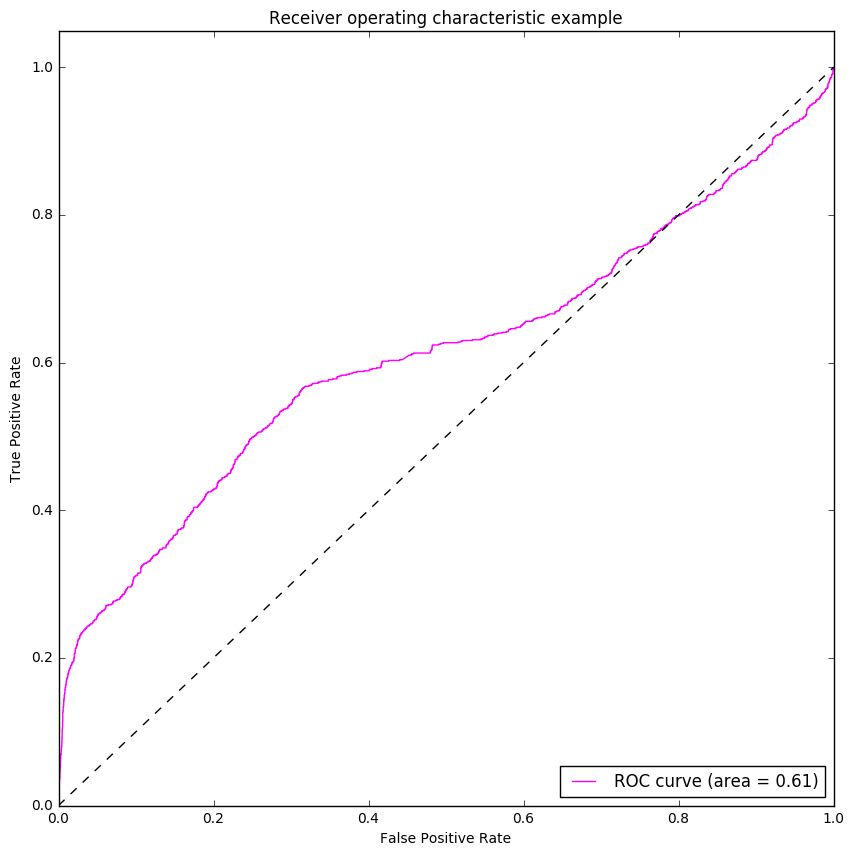

Area under the ROC curve : 0.603889


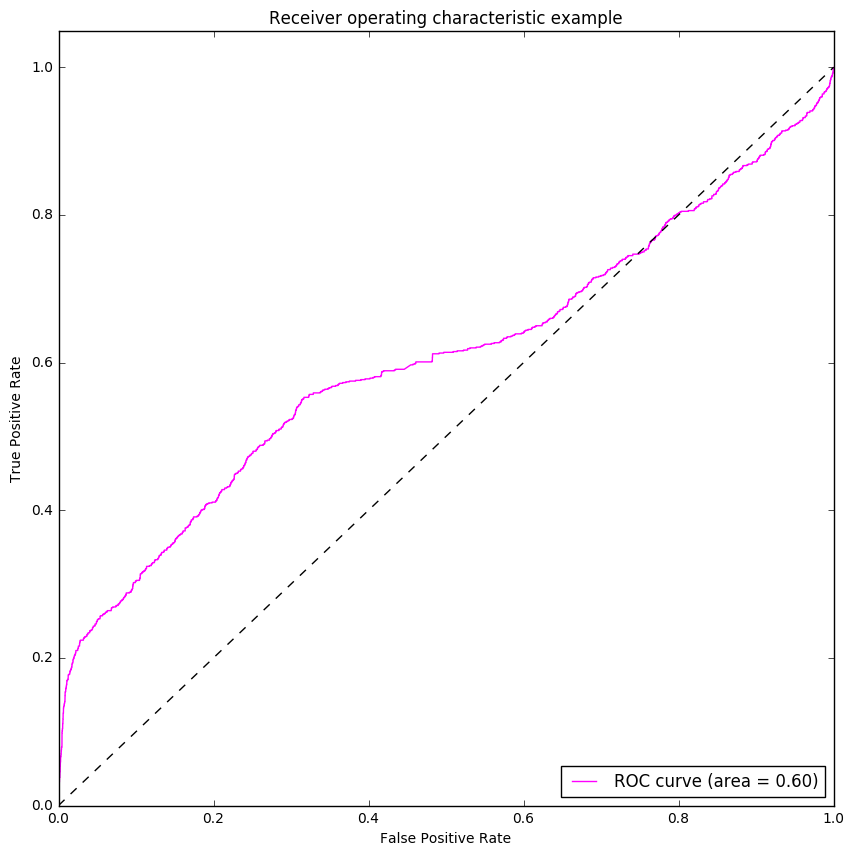

Area under the ROC curve : 0.608743


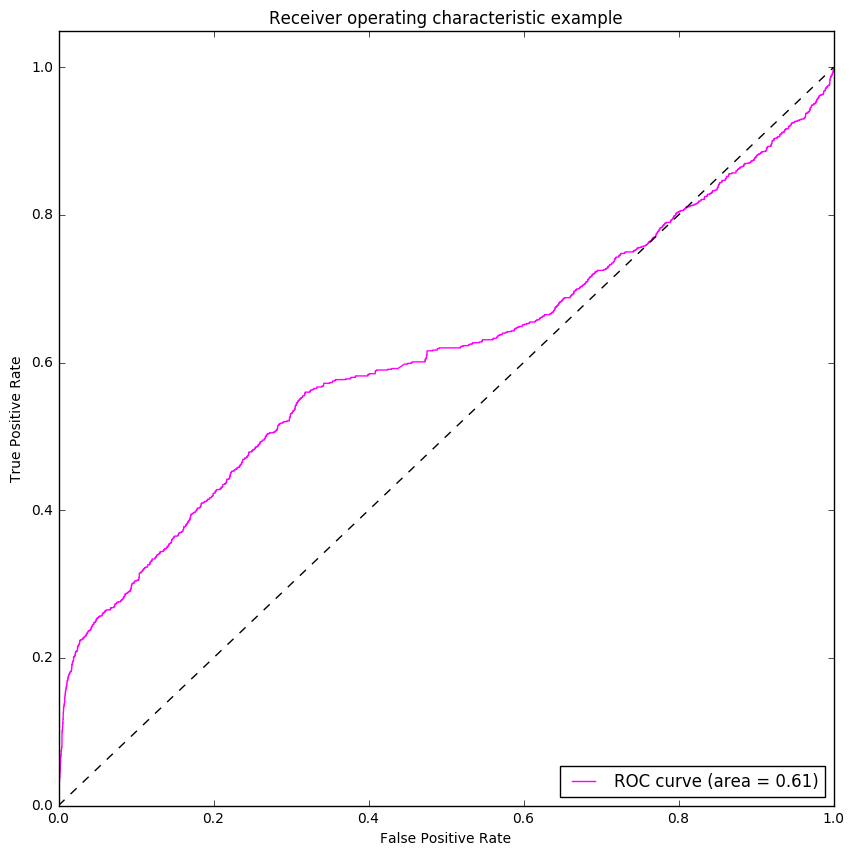

In [5]:
prefix = 'bin_svd_' if convert_to_bin_trans else 'svd_'

for s_vals in range(230, 260, 10):
    U, sigma, VT = svds(counts, k=s_vals, tol=1e-10, which = 'LM')
    pred = get_predictions_svd(U, sigma, VT, dftest)
    plot_test_roc(pred, dftest, filename='roc/' + prefix + str(s_vals) + '.png')
    np.savetxt('preds/pred_' + prefix + str(s_vals) + '.txt', pred)